In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import string
%matplotlib inline

slim = tf.contrib.slim
print(tf.__version__)

Instructions for updating:
Use the retry module or similar alternatives.
1.7.0


In [2]:
words = ['good', 'bad', 'amazing', 'so good', 'bull shit', 'awesome']
y = [[1.,0.], [0.,1.], [1.,0.], [1., 0.],[0.,1.], [1.,0.]]

In [3]:
# Character quantization
char_space = string.ascii_lowercase 
char_space = char_space + ' ' + '*'
char_space

'abcdefghijklmnopqrstuvwxyz *'

In [4]:
char_dic = {char : idx for idx, char in enumerate(char_space)}
print(char_dic)

{'x': 23, ' ': 26, 'h': 7, 'g': 6, 's': 18, 'o': 14, 'b': 1, 'i': 8, 'f': 5, 'z': 25, 'n': 13, 'j': 9, 'a': 0, 'p': 15, '*': 27, 'l': 11, 'e': 4, 'y': 24, 'u': 20, 'v': 21, 'w': 22, 't': 19, 'r': 17, 'k': 10, 'd': 3, 'q': 16, 'm': 12, 'c': 2}


In [5]:
def pad_seq(sequences, max_len, dic):
    seq_len, seq_indices = [], []
    for seq in sequences:
        seq_len.append(len(seq))
        seq_idx = [dic.get(char) for char in seq]
        seq_idx += (max_len - len(seq_idx)) * [dic.get('*')] # 27 is idx of meaningless token "*"
        seq_indices.append(seq_idx)
    return seq_len, seq_indices

In [6]:
max_length = 10
X_length, X_indices = pad_seq(sequences = words, max_len = max_length, dic = char_dic)

In [7]:
print(X_length)
print(np.shape(X_indices))

[4, 3, 7, 7, 9, 7]
(6, 10)


In [8]:
class CharStackedBiRNN:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dims, dic):
        
        with tf.variable_scope('rnn_input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable=False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            self._keep_prob = tf.placeholder(dtype=tf.float32)
            
        with tf.variable_scope('stacked_bi_rnn'):
            rnn_fw_cells = []
            for hidden_dim in hidden_dims:
                rnn_fw_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_dim,activation=tf.nn.tanh)
                rnn_fw_cell = tf.nn.rnn_cell.DropoutWrapper(cell=rnn_fw_cell, 
                                                            output_keep_prob=self._keep_prob)
                rnn_fw_cells.append(rnn_fw_cell)
            rnn_bw_cells = []
            for hidden_dim in hidden_dims:
                rnn_bw_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=hidden_dim,activation=tf.nn.tanh)
                rnn_bw_cell = tf.nn.rnn_cell.DropoutWrapper(cell=rnn_bw_cell,
                                                            output_keep_prob=self._keep_prob)
                rnn_bw_cells.append(rnn_bw_cell)
                
            _, self.output_state_fw, self.output_state_bw = \
            tf.contrib.rnn.stack_bidirectional_dynamic_rnn(cells_fw=rnn_fw_cells, cells_bw=rnn_bw_cells, 
                                                          inputs=self._X_batch,
                                                          sequence_length=self._X_length,
                                                          dtype=tf.float32)
            # [batch, hidden_unit]으로 최종 state가 나오므로 axis=1로 주어서 hidden_unit을 기준으로 concat
            final_state = tf.concat([self.output_state_fw[-1], self.output_state_bw[-1]], axis=1)
            
        with tf.variable_scope('rnn_output'):
            self._score = slim.fully_connected(inputs=final_state, num_outputs=n_of_classes,
                                              activation_fn=None)
            
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input=self._score,axis=-1,output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices, keep_prob=1.0):
        feed_prediction = {self._X_length:X_length, self._X_indices:X_indices, self._keep_prob:keep_prob}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
char_stacked_bi_rnn.output_state_bw

(<tf.Tensor 'stacked_bi_rnn/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi_rnn/stack_bidirectional_rnn/cell_1/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>)


char_stacked_bi_rnn.output_state_fw
(<tf.Tensor 'stacked_bi_rnn/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi_rnn/stack_bidirectional_rnn/cell_1/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>)
```

In [9]:
class CharStackedBiLSTM:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dims, dic):
        
        # data pipeline
        with tf.variable_scope('input_layer'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype = tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer = one_hot,
                                            trainable = False) # embedding vector training 안할 것이기 때문
            self._X_batch = tf.nn.embedding_lookup(params = self._one_hot, ids = self._X_indices)
            self._keep_prob = tf.placeholder(dtype = tf.float32)
        
        # Stacked Bi-directional LSTM with Drop out
        with tf.variable_scope('stacked_bi-directional_lstm'):
            
            # forward 
            lstm_fw_cells = []
            for hidden_dim in hidden_dims:
                lstm_fw_cell = tf.nn.rnn_cell.BasicRNNCell(num_units = hidden_dim, activation = tf.nn.tanh)
                lstm_fw_cell = tf.nn.rnn_cell.DropoutWrapper(cell = lstm_fw_cell,
                                                             output_keep_prob = self._keep_prob)
                lstm_fw_cells.append(lstm_fw_cell)
            
            # backword
            lstm_bw_cells = []
            for hidden_dim in hidden_dims:
                lstm_bw_cell = tf.nn.rnn_cell.BasicRNNCell(num_units = hidden_dim, activation = tf.nn.tanh)
                lstm_bw_cell = tf.nn.rnn_cell.DropoutWrapper(cell = lstm_bw_cell,
                                                             output_keep_prob = self._keep_prob)
                lstm_bw_cells.append(lstm_bw_cell)
            
            _, self.output_state_fw, self.output_state_bw = \
            tf.contrib.rnn.stack_bidirectional_dynamic_rnn(cells_fw = lstm_fw_cells, cells_bw = lstm_bw_cells,
                                                           inputs = self._X_batch,
                                                           sequence_length = self._X_length,
                                                           dtype = tf.float32)

            final_state = tf.concat([self.output_state_fw[-1], self.output_state_bw[-1]], axis = 1)

        with tf.variable_scope('output_layer'):
            self._score = slim.fully_connected(inputs = final_state, num_outputs = n_of_classes,
                                               activation_fn = None)
            
        with tf.variable_scope('loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels = self._y, logits = self._score)
            
        with tf.variable_scope('prediction'):
            self._prediction = tf.argmax(input = self._score, axis = -1, output_type = tf.int32)
    
    def predict(self, sess, X_length, X_indices, keep_prob = 1.):
        feed_prediction = {self._X_length : X_length, self._X_indices : X_indices, self._keep_prob : keep_prob}
        return sess.run(self._prediction, feed_dict = feed_prediction)

```python
char_stacked_bi_rnn.output_state_fw

(<tf.Tensor 'stacked_bi-directional_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi-directional_lstm/stack_bidirectional_rnn/cell_1/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>)

char_stacked_bi_rnn.output_state_bw
(<tf.Tensor 'stacked_bi-directional_lstm/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi-directional_lstm/stack_bidirectional_rnn/cell_1/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>)
```

In [10]:
class CharStackBiGRU:
    def __init__(self, X_length, X_indices, y, n_of_classes, hidden_dims, dic):
        
        with tf.variable_scope('gru_input'):
            self._X_length = X_length
            self._X_indices = X_indices
            self._y = y
            
            one_hot = tf.eye(len(dic), dtype=tf.float32)
            self._one_hot = tf.get_variable(name='one_hot_embedding', initializer=one_hot,
                                           trainable = False)
            self._X_batch = tf.nn.embedding_lookup(params=self._one_hot, ids=self._X_indices)
            self._keep_prob = tf.placeholder(dtype=tf.float32)
            
        with tf.variable_scope('stacked_bi_gru'):
            
            gru_fw_cells = []
            for hidden_dim in hidden_dims:
                gru_fw_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim,activation=tf.nn.tanh)
                gru_fw_cell = tf.nn.rnn_cell.DropoutWrapper(cell=gru_fw_cell,output_keep_prob=self._keep_prob)
                gru_fw_cells.append(gru_fw_cell)
                
            gru_bw_cells = []
            for hidden_dim in hidden_dims:
                gru_bw_cell = tf.nn.rnn_cell.GRUCell(num_units=hidden_dim,activation=tf.nn.tanh)
                gru_bw_cell = tf.nn.rnn_cell.DropoutWrapper(cell=gru_bw_cell,output_keep_prob=self._keep_prob)
                gru_bw_cells.append(gru_bw_cell)
            
            _, self.output_state_fw, self.output_state_bw = \
            tf.contrib.rnn.stack_bidirectional_dynamic_rnn(cells_fw = gru_fw_cells, cells_bw = gru_bw_cells,
                                                           inputs = self._X_batch,
                                                           sequence_length = self._X_length,
                                                           dtype = tf.float32)
            
            final_state = tf.concat([self.output_state_fw[-1], self.output_state_bw[-1]], axis=1)
            
        with tf.variable_scope('gur_output'):
            self._score = slim.fully_connected(inputs=final_state,num_outputs=n_of_classes,activation_fn=None)
            
        with tf.variable_scope('gru_loss'):
            self.ce_loss = tf.losses.softmax_cross_entropy(onehot_labels=self._y, logits=self._score)
            
        with tf.variable_scope('gru_prediction'):
            self._prediction = tf.argmax(input=self._score, axis=-1, output_type=tf.int32)
            
    def predict(self, sess, X_length, X_indices, keep_prob=1.0):
        feed_prediction={self._X_length:X_length, self._X_indices:X_indices, self._keep_prob:keep_prob}
        return sess.run(self._prediction, feed_dict=feed_prediction)

```python
char_stacked_bi_rnn.output_state_bw

(<tf.Tensor 'stacked_bi_gru/stack_bidirectional_rnn/cell_0/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi_gru/stack_bidirectional_rnn/cell_1/bidirectional_rnn/bw/bw/while/Exit_3:0' shape=(?, 16) dtype=float32>)

char_stacked_bi_rnn.output_state_fw
(<tf.Tensor 'stacked_bi_gru/stack_bidirectional_rnn/cell_0/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>,
 <tf.Tensor 'stacked_bi_gru/stack_bidirectional_rnn/cell_1/bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 16) dtype=float32>)
```

In [11]:
lr = 0.003
epochs = 10
batch_size = 2
total_step = int(np.shape(X_indices)[0] / batch_size)
print(total_step)

3


In [12]:
tr_dataset = tf.data.Dataset.from_tensor_slices((X_length, X_indices, y))

In [13]:
tr_dataset = tr_dataset.shuffle(buffer_size=20)
tr_dataset = tr_dataset.batch(batch_size=batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()
print(tr_dataset)

<BatchDataset shapes: ((?,), (?, 10), (?, 2)), types: (tf.int32, tf.int32, tf.float32)>


In [14]:
X_length_mb, X_indices_mb, y_mb = tr_iterator.get_next()

In [15]:
char_stacked_bi_rnn = CharStackBiGRU(X_length=X_length_mb, X_indices=X_indices_mb,
                                      y=y_mb, n_of_classes=2, hidden_dims=[16,16], dic=char_dic)

In [17]:
opt = tf.train.AdamOptimizer(learning_rate=lr)
training_op = opt.minimize(char_stacked_bi_rnn.ce_loss)

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

tr_loss_hist = []

for epoch in range(epochs):
    avg_tr_loss = 0
    tr_step = 0
    
    sess.run(tr_iterator.initializer)
    try:
        while True:
            _, tr_loss = sess.run([training_op, char_stacked_bi_rnn.ce_loss],
                                 feed_dict={char_stacked_bi_rnn._keep_prob : 0.5})
            avg_tr_loss += tr_loss
            tr_step +=1
    except tf.errors.OutOfRangeError:
        pass
    
    avg_tr_loss /= tr_step
    tr_loss_hist.append(avg_tr_loss)
    
    print('epoch : {:3}, tr_loss: {:.3f}'.format(epoch+1, avg_tr_loss))

epoch :   1, tr_loss: 1.106
epoch :   2, tr_loss: 0.680
epoch :   3, tr_loss: 0.651
epoch :   4, tr_loss: 0.433
epoch :   5, tr_loss: 0.414
epoch :   6, tr_loss: 0.368
epoch :   7, tr_loss: 0.288
epoch :   8, tr_loss: 0.200
epoch :   9, tr_loss: 0.165
epoch :  10, tr_loss: 0.190


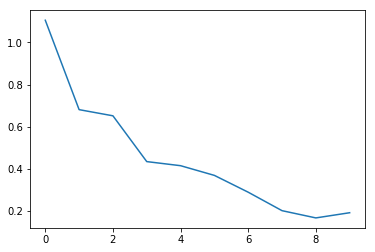

In [19]:
plt.plot(tr_loss_hist, label='train')

In [20]:
yhat = char_stacked_bi_rnn.predict(sess, X_length, X_indices)

In [21]:
print('trainign acc:{:.2%}'.format(np.mean(yhat==np.argmax(y, axis=-1))))

trainign acc:100.00%
